# Autoencoder-for-HTTP-Log-Anomaly-Detection

Syslog 데이터를 이용하여 Autoencoder Anomaly Detection 진행.

---

## Simple EDA

In [1]:
# 파일 확인
!ls "./data"

HDFS_100k.log_anomaly_label.csv  log_model_HDFS.h5		  syslog.txt
HDFS_100k.log_structured.csv	 SHISO_syslog.txt_structured.csv  syslog.xls
LenMa_syslog.txt_structured.csv  SHISO_syslog.txt_templates.csv   weblog.csv
LenMa_syslog.txt_templates.csv	 syslog.csv


In [2]:
# import section
from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import  Model, Sequential
from keras.layers import Dense, Input, LSTM ,Embedding , RepeatVector, TimeDistributed
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd

In [3]:
df = pd.read_excel('./data/syslog.xls')

In [4]:
df

,심각도,발생 일시,그룹경로,시스템명,호스트명,리소스 이름,대상,이벤트 타입,이벤트 소스,내용
0,ERROR,2021-01-08 11:39:07,인프라그룹,Syslog Receiver,NaN,Syslog Receiver,인프라그룹>Syslog Receiver,syslog,172.30.151.88,[syslog]<43>Jan 8 11:39:07 Kolon_L7_trust_02 ...
1,ERROR,2021-01-08 11:39:07,인프라그룹,Syslog Receiver,NaN,Syslog Receiver,인프라그룹>Syslog Receiver,syslog,172.30.151.88,[syslog]<43>Jan 8 11:39:07 Kolon_L7_trust_02 ...
2,ERROR,2021-01-08 11:39:06,인프라그룹,Syslog Receiver,NaN,Syslog Receiver,인프라그룹>Syslog Receiver,syslog,172.30.151.87,[syslog]<43>Jan 8 11:39:06 Kolon_L7_trust_01 ...
3,ERROR,2021-01-08 11:38:07,인프라그룹,Syslog Receiver,NaN,Syslog Receiver,인프라그룹>Syslog Receiver,syslog,172.30.151.88,[syslog]<43>Jan 8 11:38:07 Kolon_L7_trust_02 ...
4,ERROR,2021-01-08 11:38:07,인프라그룹,Syslog Receiver,NaN,Syslog Receiver,인프라그룹>Syslog Receiver,syslog,172.30.151.88,[syslog]<43>Jan 8 11:38:07 Kolon_L7_trust_02 ...
...,...,...,...,...,...,...,...,...,...,...
9995,ERROR,2021-01-06 18:32:06,인프라그룹,Syslog Receiver,NaN,Syslog Receiver,인프라그룹>Syslog Receiver,syslog,172.30.151.88,[syslog]<43>Jan 6 18:32:06 Kolon_L7_trust_02 ...
9996,ERROR,2021-01-06 18:31:10,인프라그룹,Syslog Receiver,NaN,Syslog Receiver,인프라그룹>Syslog Receiver,syslog,172.30.151.87,[syslog]<43>Jan 6 18:31:10 Kolon_L7_trust_01 ...
9997,ERROR,2021-01-06 18:31:10,인프라그룹,Syslog Receiver,NaN,Syslog Receiver,인프라그룹>Syslog Receiver,syslog,172.30.151.87,[syslog]<43>Jan 6 18:31:10 Kolon_L7_trust_01 ...
9998,ERROR,2021-01-06 18:31:06,인프라그룹,Syslog Receiver,NaN,Syslog Receiver,인프라그룹>Syslog Receiver,syslog,172.30.151.88,[syslog]<43>Jan 6 18:31:06 Kolon_L7_trust_02 ...


In [5]:
# simple EDA
df.isna().sum()

심각도           0
발생 일시         0
그룹경로          0
시스템명          0
호스트명      10000
리소스 이름        0
대상            0
이벤트 타입        0
이벤트 소스        0
내용            0
dtype: int64

In [6]:
# simple EDA
for i in df.columns:
    print(i)
    print(df[i].factorize())
    print(' === ')

심각도
(array([0, 0, 0, ..., 0, 0, 0]), Index(['ERROR'], dtype='object'))
 === 
발생 일시
(array([   0,    0,    1, ..., 4408, 4409, 4409]), Index(['2021-01-08 11:39:07', '2021-01-08 11:39:06', '2021-01-08 11:38:07',
       '2021-01-08 11:38:06', '2021-01-08 11:37:07', '2021-01-08 11:37:06',
       '2021-01-08 11:36:07', '2021-01-08 11:36:06', '2021-01-08 11:35:07',
       '2021-01-08 11:35:06',
       ...
       '2021-01-06 18:35:10', '2021-01-06 18:35:06', '2021-01-06 18:34:10',
       '2021-01-06 18:34:06', '2021-01-06 18:33:10', '2021-01-06 18:33:06',
       '2021-01-06 18:32:10', '2021-01-06 18:32:06', '2021-01-06 18:31:10',
       '2021-01-06 18:31:06'],
      dtype='object', length=4410))
 === 
그룹경로
(array([0, 0, 0, ..., 0, 0, 0]), Index(['인프라그룹'], dtype='object'))
 === 
시스템명
(array([0, 0, 0, ..., 0, 0, 0]), Index(['Syslog Receiver'], dtype='object'))
 === 
호스트명
(array([-1, -1, -1, ..., -1, -1, -1]), Float64Index([], dtype='float64'))
 === 
리소스 이름
(array([0, 0, 0, ..., 0, 0, 0]), Index

In [7]:
df.내용.str.split(' ').str[4].unique()

array(['Kolon_L7_trust_02', 'Kolon_L7_trust_01', '-', 'iken'],
      dtype=object)

In [8]:
# # Data Change for parsing log
# for line in df.내용.str.strip():
#     with open('./syslog.txt','w') as f:
#         f.wirte(line + '\n')

## Neural Netowork Autoencoder 
logparser의 LenMa 를 적용한 데이터

In [5]:
struct_log = './data/LenMa_syslog.txt_structured.csv' # The structured log file

In [6]:
df = pd.read_csv(struct_log)

In [7]:
df

,LineId,Address,Month,Date,Time,User,Component,PID,Content,EventId,EventTemplate
0,1,172.30.151.88,[syslog]<43>Jan,6,18:31:06,Kolon_L7_trust_02,err syslog-ng,12499,POLLERR occurred while idle; fd='39',cd088b8c,POLLERR occurred while idle; fd='39'
1,2,172.30.151.88,[syslog]<43>Jan,8,11:39:07,Kolon_L7_trust_02,err syslog-ng,12499,Connection broken; time_reopen='60',921393f5,Connection broken; time_reopen='60'
2,3,172.30.151.88,[syslog]<43>Jan,8,11:39:07,Kolon_L7_trust_02,err syslog-ng,12499,POLLERR occurred while idle; fd='39',cd088b8c,POLLERR occurred while idle; fd='39'
3,4,172.30.151.87,[syslog]<43>Jan,8,11:39:06,Kolon_L7_trust_01,err syslog-ng,12592,Connection broken; time_reopen='60',921393f5,Connection broken; time_reopen='60'
4,5,172.30.151.88,[syslog]<43>Jan,8,11:38:07,Kolon_L7_trust_02,err syslog-ng,12499,Connection broken; time_reopen='60',921393f5,Connection broken; time_reopen='60'
...,...,...,...,...,...,...,...,...,...,...,...
9908,9909,172.30.151.88,[syslog]<43>Jan,6,18:32:06,Kolon_L7_trust_02,err syslog-ng,12499,Connection broken; time_reopen='60',921393f5,Connection broken; time_reopen='60'
9909,9910,172.30.151.87,[syslog]<43>Jan,6,18:31:10,Kolon_L7_trust_01,err syslog-ng,12592,Connection broken; time_reopen='60',921393f5,Connection broken; time_reopen='60'
9910,9911,172.30.151.87,[syslog]<43>Jan,6,18:31:10,Kolon_L7_trust_01,err syslog-ng,12592,"I/O error occurred while writing; fd='39', err...",0f51431f,"I/O error occurred while writing; fd='39', err..."
9911,9912,172.30.151.88,[syslog]<43>Jan,6,18:31:06,Kolon_L7_trust_02,err syslog-ng,12499,Connection broken; time_reopen='60',921393f5,Connection broken; time_reopen='60'


In [8]:
# simple EDA
df.isna().sum()

LineId           0
Address          0
Month            0
Date             0
Time             0
User             0
Component        0
PID              0
Content          0
EventId          0
EventTemplate    0
dtype: int64

In [9]:
# simple EDA
for i in df.columns:
    print(i)
    print(df[i].unique())
    print(len(df[i].unique()))
    print(' === ')

LineId
[   1    2    3 ... 9911 9912 9913]
9913
 === 
Address
['172.30.151.88' '172.30.151.87' '172.30.151.188' '172.30.151.187']
4
 === 
Month
['[syslog]<43>Jan' '[local0]<131>Jan']
2
 === 
Date
[6 8 7]
3
 === 
Time
['18:31:06' '11:39:07' '11:39:06' ... '18:32:10' '18:32:06' '18:31:10']
3598
 === 
User
['Kolon_L7_trust_02' 'Kolon_L7_trust_01' 'iken']
3
 === 
Component
['err syslog-ng' 'err tmm1' 'err tmm']
3
 === 
PID
[12499 12592 11947 11994 19367 19374]
6
 === 
Content
["POLLERR occurred while idle; fd='39'"
 "Connection broken; time_reopen='60'"
 "I/O error occurred while writing; fd='39', error='Connection refused (111)'"
 "Duplicate stats counter; counter='udp((null):514)'"
 '01010028:3: No members available for pool /Common/p_media_9005'
 '01010221:3: Pool /Common/p_media_9005 now has available members']
6
 === 
EventId
['cd088b8c' '921393f5' '0f51431f' '0c8789f9' '21e8db60' '8a82bb94']
6
 === 
EventTemplate
["POLLERR occurred while idle; fd='39'"
 "Connection broken; time_reope

### Train

In [10]:
struct_log = './data/LenMa_syslog.txt_structured.csv' # The structured log file

In [11]:
from utils import dataloader
from utils.preprocessing import Vectorizer_sys


batch_size = 32
hidden_size = 32
num_directions = 2
topk = 5
train_ratio = 0.2
window_size = 10
epoches = 2
num_workers = 2
device = 0 

x_, window_y_ = \
dataloader.load_sys(struct_log, window='session', window_size=window_size, train_ratio=train_ratio, split_type='uniform')

====== Input data summary ======
Loading ./data/LenMa_syslog.txt_structured.csv
Slicing 6 sessions, with window 10
Slicing done, 9875 windows generated
Train: windows


In [12]:
x_.EventSequence[0]

['cd088b8c',
 '921393f5',
 'cd088b8c',
 '921393f5',
 'cd088b8c',
 '921393f5',
 'cd088b8c',
 '921393f5',
 'cd088b8c',
 '921393f5']

In [13]:
feature_extractor = Vectorizer_sys()
train_dataset = feature_extractor.fit_transform(x_, window_y_)

In [14]:
train_dataset

{'SessionId': array([0, 0, 0, ..., 3, 4, 5]),
 'window_y': array([2, 3, 2, ..., 1, 1, 1]),
 'x': array([[2, 3, 2, ..., 3, 2, 3],
        [3, 2, 3, ..., 2, 3, 2],
        [2, 3, 2, ..., 3, 2, 3],
        ...,
        [5, 5, 5, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 1, 1]])}

In [15]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath='./data/log_model_HDFS.h5'
    )
]

In [16]:
# NN Autoencoder model.
input_dim = train_dataset['x'].shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(input_dim//3*2, activation='relu')(input)
encode = Dense(input_dim//3, activation='relu')(encode)
encode = Dense(1, activation='relu')(encode)

decode = Dense(input_dim//3, activation='relu')(encode)
decode = Dense(input_dim//3*2, activation='relu')(decode)
decode = Dense(input_dim, activation='sigmoid')(decode)

autoencoder = Model(input, decode)


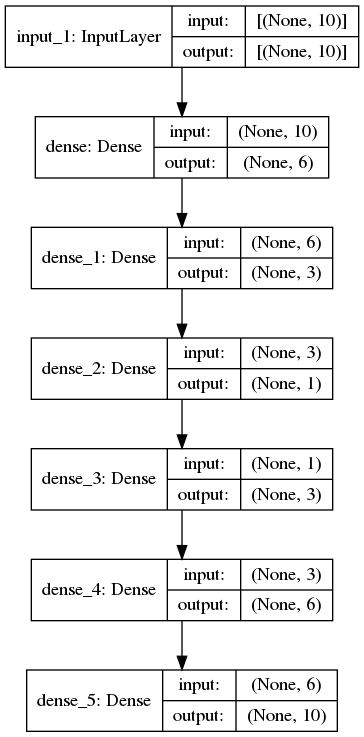

In [17]:
plot_model(autoencoder, to_file='./data/model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
# Create 6 layer model.
input_dim = train_dataset['x'].shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(input_dim//3*2, activation='relu')(input)
encode = Dense(input_dim//3, activation='relu')(encode)
encode = Dense(1, activation='relu')(encode)

decode = Dense(input_dim//3, activation='relu')(encode)
decode = Dense(input_dim//3*2, activation='relu')(decode)
decode = Dense(input_dim, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
autoencoder.summary()

autoencoder.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['accuracy'])

# Train model.
history = autoencoder.fit(train_dataset['x'], train_dataset['x'],
        epochs=100,
        batch_size=32,
        callbacks=callbacks_list,
        shuffle=True
        )

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 66        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6         
_________________________________________________________________
dense_4 (Dense)              (None, 6)       

### Check the result

In [21]:
import pandas as pd

# Combined x and x_test.
new_x = train_dataset['x']

predictions = autoencoder.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# Set threshold at the 99th quartile.
threshold = error_df.quantile(0.99)

error_df.describe()

,reconstruction_error
count,9875.000000
mean,2.991808
std,0.743934
min,0.051182
25%,2.500000
50%,2.800000
75%,3.300000
max,9.500000


(array([2.000e+00, 4.933e+03, 4.472e+03, 3.690e+02, 6.600e+01, 1.300e+01,
        2.000e+01]),
 array([0.05118219, 1.4010133 , 2.75084442, 4.10067554, 5.45050665,
        6.80033777, 8.15016888, 9.5       ]),
 <BarContainer object of 7 artists>)

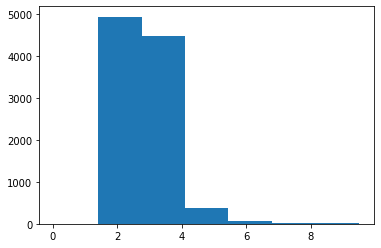

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

# Reconstruction error binned and plotted.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(error_df.reconstruction_error.values, bins=7)

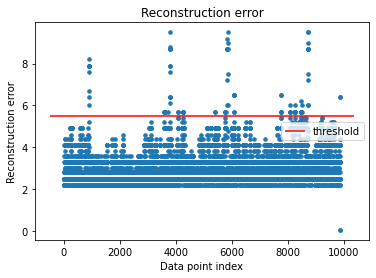

In [23]:
threshold = threshold

# Plot reconstruction error vs. the data.
fig, ax = plt.subplots()
ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='threshold')
ax.legend(loc=5)
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Output anomalies.
index_list = []
for index, row in error_df.iterrows():
    if row.reconstruction_error > int(threshold):
        index_list.append(index)

output = []    
for x in index_list:
    output.append(new_x[x])


## LSTM Autoencoder

In [7]:
x = np.expand_dims(train_dataset['x'],axis=1)


In [2]:
# LSTM Autoencoder
model = Sequential()

# Encoder
model.add(LSTM(8, activation='relu', input_shape=(1,10), return_sequences=True))
model.add(LSTM(4, activation='relu', return_sequences=True))
model.add(LSTM(1, activation='relu', return_sequences=True))
# model.add(RepeatVector(10))

# Decoder
model.add(LSTM(4, activation='relu', return_sequences=True))
model.add(LSTM(8, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(10)))

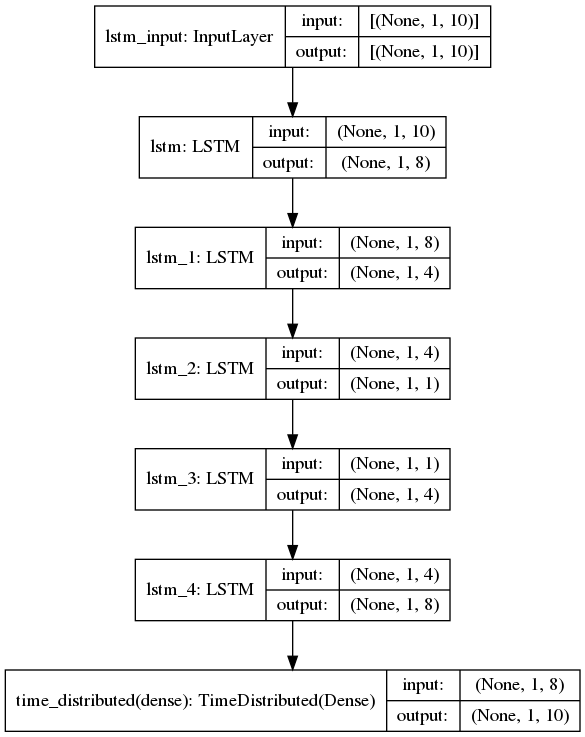

In [3]:
plot_model(model, to_file='./data/LSTM_model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

# fit
history = model.fit(x, x,
                     epochs=100, batch_size=32)

Epoch 1/100
309/309 [==============================] - 4s 3ms/step - loss: 6.0507 - accuracy: 0.2746
Epoch 2/100
309/309 [==============================] - 1s 3ms/step - loss: 0.4950 - accuracy: 0.2422
Epoch 3/100
309/309 [==============================] - 1s 3ms/step - loss: 0.3356 - accuracy: 0.0806
Epoch 4/100
309/309 [==============================] - 1s 3ms/step - loss: 0.3322 - accuracy: 0.1102
Epoch 5/100
309/309 [==============================] - 1s 3ms/step - loss: 0.3304 - accuracy: 0.1231
Epoch 6/100
309/309 [==============================] - 1s 3ms/step - loss: 0.3311 - accuracy: 0.0790
Epoch 7/100
309/309 [==============================] - 1s 3ms/step - loss: 0.3339 - accuracy: 0.0548
Epoch 8/100
309/309 [==============================] - 1s 3ms/step - loss: 0.3311 - accuracy: 0.0944
Epoch 9/100
309/309 [==============================] - 1s 3ms/step - loss: 0.3317 - accuracy: 0.1491
Epoch 10/100
309/309 [==============================] - 1s 3ms/step - loss: 0.3326 - accura